<a href="https://colab.research.google.com/github/k1-furuya/rstan001/blob/main/%E3%83%99%E3%82%A4%E3%82%BAAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

従来のWEBページAと、改善後のページBをランダムに表示するABテストを実施し、その効果を検証する。意図的にサンプルサイズは小さくしている。

In [ ]:
import pandas as pd
# 使うデータの視覚化
data = {
    'ページ': ['従来のページ', '改善後のページ'],
    '表示数': [40, 25],
    'クリック数': [2, 2]
}
df = pd.DataFrame(data)

df

,ページ,表示数,クリック数
0,従来のページ,40,2
1,改善後のページ,25,2


In [ ]:
%matplotlib inline
# 日本語化ライブラリ導入
!pip install japanize-matplotlib | tail -n 1

In [ ]:
# ライブラリのインポート

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams['figure.figsize'] = (6, 6)
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [ ]:
import pymc as pm
import arviz as az

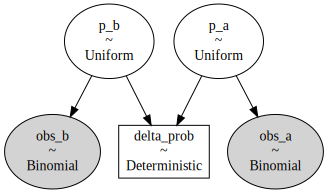

In [ ]:
model_s = pm.Model()

with pm.Model() as model_s:
    # 事前分布として一様分布を採用　#今回は事前知識がないと仮定して、主観的な信念の影響を最小限にするための一様分布
    p_a = pm.Uniform('p_a', lower=0.0, upper=1.0)
    p_b = pm.Uniform('p_b', lower=0.0, upper=1.0)

    # 二項分布で確率モデルを定義
    # n:表示数　observed:クリック数
    obs_a = pm.Binomial('obs_a', p=p_a, n=40, observed=2)
    obs_b = pm.Binomial('obs_b', p=p_b, n=25, observed=2)

    # 新たな確率変数として二つの確率変数の差を定義
    delta_prob = pm.Deterministic('delta_prob', p_b - p_a)

# 確率モデル構造可視化
g = pm.model_to_graphviz(model_s)
display(g)

In [ ]:
with model_s:
    idata_s = pm.sample(random_seed=1, target_accept=0.99)

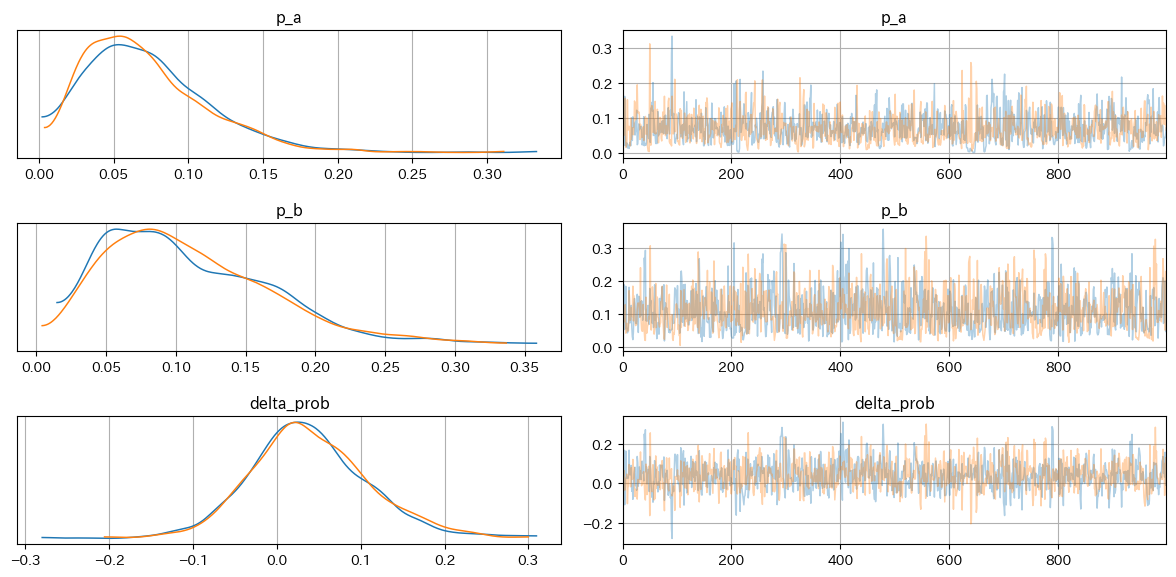

In [ ]:
az.plot_trace(idata_s, compact=False)
plt.tight_layout();

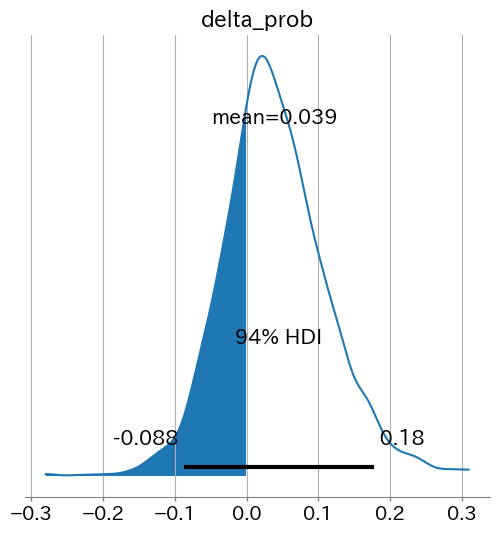

In [ ]:
ax = az.plot_posterior(idata_s, var_names=['delta_prob'])
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx<0], yy[xx<0]);

# コンバージョン率の差が、95％の確率で約-0.088~0.18の間にあると信じられる

In [ ]:
# サンプリング結果から　delta_probの値を抽出
delta_prob_s = idata_s['posterior'].data_vars['delta_prob']
delta_prob_s_values = delta_prob_s.values.reshape(-1)

# delta_probの値がマイナスであった件数　# マイナスつまりAがクリックされた
n1_s = (delta_prob_s_values < 0).sum()

# 全体サンプル数
n_s = len(delta_prob_s_values)

# 比率計算
n1_rate_s = n1_s/n_s
print(f'画面Aの方がクリック率が高い確率: {n1_rate_s*100:.02f}%')

画面Aの方がクリック率が高い確率: 28.35%


Bのほうがクリック率が高いという仮説が約3回に1回は外れるということ。
現時点でBのほうがクリック率が高いという仮説を立てるのにはリスクがあり、サンプル数が少ないため、たまたまそうなっている可能性があります。ベイズ手法では、データが手に入るたびに事後分布を更新して、それを新たな事前分布として活用することができます。

したがって、信頼区間が広く統計的な有意差が確認できない場合でも、ベイズ推論を用いることで事前情報を組み込み、データの不確実性を直接的に評価し、より実践的な意思決定をサポートすることが可能であるという理由でABテストにおいてベイズ推論を用いるモチベーションが高いと考えられます。